# Setup

In [2]:
# !pip install -U -q segmentation-models
# !pip install -q tensorflow==2.1
# !pip install -q keras==2.3.1
# !pip install -q tensorflow-estimator==2.1.

# ## Imports libs
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ["SM_FRAMEWORK"] = "tf.keras"

# from tensorflow import keras
# import segmentation_models as sm

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
from keras.preprocessing import sequence
import random
import matplotlib.pyplot as plt
import copy

Using TensorFlow backend.


In [91]:
def create_letter_mapping(all_words):
    letter_li = []
    
    # Get unique letters in the data
    for word in all_words:
        for letter in word:
            letter_li.append(letter)
    
    # order letters by most common
    most_common = Counter(letter_li).most_common()
    letter_li = []
    for elem in most_common:
        letter_li.append(elem[0])
    
    # Map each letter to an integer
    letter_dict = {}
    for idx, letter in enumerate(letter_li):
        if letter_dict != '':
            letter_dict[letter] = idx + 1
        else:
            letter_dict[letter] = 0
    
    return letter_dict

def letter_to_number(word_li, letter_dict):
    return_li = []
    for letter in word_li:
        return_li.append(letter_dict[letter])
        
    return return_li

def pad_list(letter_li, pad_num=25):
    curr_len = len(letter_li)
    new_len = 25 - curr_len
    zeroes = [0] * new_len
    zeroes.extend(letter_li)
    return zeroes

def convert_prediction(pred_list):
    max_value = -100
    max_idx = -1
    for idx,value in enumerate(pred_list):
        if value > max_value:
            max_value = value
            max_idx = idx
    
    return max_idx

# Fixing Language Groups

In [171]:
lan_df = pd.read_csv('language_data.csv')

In [172]:
lan_df.fillna('Other', inplace=True)

In [173]:
lan_df.loc[lan_df['full_name'].str.contains('English'), 'Group'] = 'Germanic'
lan_df.loc[lan_df['full_name'].str.contains('Dutch'), 'Group'] = 'Germanic'
lan_df.loc[lan_df['full_name'].str.contains('Norse'), 'Group'] = 'Germanic'
lan_df.loc[lan_df['full_name'].str.contains('Germ'), 'Group'] = 'Germanic'

lan_df.loc[lan_df['full_name'].str.contains('French'), 'Group'] = 'Latin'
lan_df.loc[lan_df['full_name'].str.contains('Greek'), 'Group'] = 'Greek'
lan_df.loc[lan_df['full_name'].str.contains('Hebrew'), 'Group'] = 'Other'

lan_df.loc[lan_df['full_name'] == 'Sanskrit', 'Group'] = 'Indo-Aryan'
lan_df.loc[lan_df['full_name'] == 'Hindi', 'Group'] = 'Indo-Aryan'

#lan_df = lan_df[lan_df['Group'] != 'Arabic']
lan_df = lan_df[lan_df['Group'] != 'Turkish']
#lan_df = lan_df[lan_df['Group'] != 'Indo-Aryan']


lan_df = lan_df[lan_df['Group'] != 'Other']

# Date Cleanup

In [174]:
lan_df.reset_index(inplace=True,drop=True)

In [175]:
group_dict = {'Germanic': 0, 'Greek': 1, 'Latin': 2, 'Japanese': 3,'Indo-Aryan': 4, 'Arabic' : 5}

In [176]:
lan_df['group_int'] = lan_df['Group'].apply(lambda x: group_dict[x])

In [177]:
lan_df['letter_li'] = lan_df['word'].apply(lambda x: list(x))

In [178]:
map_dict = create_letter_mapping(lan_df['word'].values)

In [179]:
lan_df['letter_ints'] = lan_df['letter_li'].apply(lambda x: pad_list(letter_to_number(x, map_dict)))

In [180]:
SHAPE = lan_df.shape[0]

In [181]:
word_arr = np.empty(SHAPE, dtype=list)
origin_arr = np.empty(SHAPE, dtype=int)

In [182]:
for i in range(SHAPE):
    word_arr[i] = lan_df.loc[i, 'letter_ints']
    origin_arr[i] = lan_df.loc[i, 'group_int']

In [183]:
# pad array so that all words have length of 25
word_arr = sequence.pad_sequences(word_arr, 25)

In [184]:
# Develop random index for train test split
random.seed(0)
rng = np.arange(SHAPE)
random.shuffle(rng)

In [185]:
train_len = int(SHAPE * 0.7)
train_idx = rng[:train_len]
test_idx = rng[train_len:]

In [186]:
X_train, y_train = word_arr[train_idx], origin_arr[train_idx]
X_test, y_test = word_arr[test_idx], origin_arr[test_idx]

# Models

In [187]:
EMBEDDING_LAYERS = 64
GROUPS = len(group_dict)

embedding_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(map_dict) + 1, EMBEDDING_LAYERS),
    tf.keras.layers.LSTM((EMBEDDING_LAYERS + GROUPS) // 2, return_sequences=False),
#     tf.keras.layers.LSTM(50, return_sequences=True),
#     tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(GROUPS, activation="softmax")
])

In [188]:
embedding_model.compile(loss="sparse_categorical_crossentropy",optimizer="rmsprop",metrics=['acc'])
history = embedding_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Train on 31669 samples, validate on 7918 samples
Epoch 1/10
31669/31669 [==============================] - 12s 369us/sample - loss: 0.8229 - acc: 0.6617 - val_loss: 0.7471 - val_acc: 0.6916
Epoch 2/10
31669/31669 [==============================] - 10s 327us/sample - loss: 0.7284 - acc: 0.6927 - val_loss: 0.7291 - val_acc: 0.6893
Epoch 3/10
31669/31669 [==============================] - 12s 387us/sample - loss: 0.7022 - acc: 0.7037 - val_loss: 0.7073 - val_acc: 0.6985
Epoch 4/10
31669/31669 [==============================] - 11s 333us/sample - loss: 0.6835 - acc: 0.7112 - val_loss: 0.6744 - val_acc: 0.7242
Epoch 5/10
31669/31669 [==============================] - 11s 336us/sample - loss: 0.6615 - acc: 0.7236 - val_loss: 0.6649 - val_acc: 0.7306
Epoch 6/10
31669/31669 [==============================] - 11s 335us/sample - loss: 0.6410 - acc: 0.7310 - val_loss: 0.6492 - val_acc: 0.7330
Epoch 7/10
31669/31669 [==============================] - 11s 338us/sample - loss: 0.6228 - acc: 0.7422 -

# Predicting Individual Words

In [189]:
def get_word_prediction(test_word, model):
    temp = pad_list(letter_to_number(list(test_word), map_dict))
    temp = model.predict(np.array([temp]))
    temp_df = pd.DataFrame(data={'group':[elem for elem in group_dict.keys()], 'probability' : temp[0] * 100})
    return temp_df

In [190]:
get_word_prediction('sjdfklasfa', embedding_model)

,group,probability
0,Germanic,21.524614
1,Greek,0.354016
2,Latin,10.848943
3,Japanese,6.109216
4,Indo-Aryan,43.251564
5,Arabic,17.911650


# Prediction Accuracy

In [191]:
preds = embedding_model.predict(X_test)

In [192]:
def create_language_df(preds):
    result_list = []
    germ_li = []
    greek_li = []
    latin_li = []
    jp_li = []
    indo_li = []
    arab_li = []

    for elem in preds:
        result_list.append(convert_prediction(elem))
        germ_li.append(elem[0])
        greek_li.append(elem[1])
        latin_li.append(elem[2])
        jp_li.append(elem[3])
        indo_li.append(elem[4])
        arab_li.append(elem[5])
        
    result_df = pd.DataFrame(data={'y_actual': y_test, 
        'y_pred': result_list,
        'prob_germanic' : germ_li,
        'prob_greek': greek_li,
        'prob_latin' : latin_li,
        'prob_japanese' : jp_li,
        'prob_indo' : indo_li,
         'prob_arabic' : arab_li})

    result_df['correct'] =  1.0 * (result_df['y_actual'] == result_df['y_pred'])
    
    result_df['is_germanic'] = 1 * (result_df['y_actual'] == 0)
    result_df['is_greek'] = 1 * (result_df['y_actual'] == 1)
    result_df['is_latin'] = 1 * (result_df['y_actual'] == 2)
    result_df['is_japanese'] = 1 * (result_df['y_actual'] == 3)
    result_df['is_indo'] = 1 * (result_df['y_actual'] == 4)
    result_df['is_arabic'] = 1 * (result_df['y_actual'] == 5)
    
    return result_df

In [193]:
result_df = create_language_df(preds)

In [194]:
class LiftGraphMaker:

    def __init__(self, df):
        self.df = df
    
    def plot_calibration(self, language):
        prob_col = 'prob_' + language
        true_col = 'is_' + language
        
        result_df = self.df
        
        avg_li = []
        pred_li = []
        for x in range(0,100,10):
            num1, num2 = x, x + 10
            avg_li.append((num1+num2)/2)
            pred_li.append(result_df.loc[(result_df[prob_col] >= num1 / 100) & 
                       (result_df[prob_col] <= num2 / 100), true_col].mean() * 100)
            
        plt.rcParams["figure.figsize"] = (9,7)
        plt.plot([0,100], [0,100], label='Perfect', linestyle='--', color = 'grey')
        plt.plot(avg_li, pred_li, label='Model', color = 'red')
        plt.legend()
        
    def plot_lift(self, language, ratio=False):
        
        prob_col = 'prob_' + language
        true_col = 'is_' + language
        
        result_df = self.df
        result_df.sort_values(prob_col, ascending=False, inplace=True)
        lift_df = copy.deepcopy(result_df)

        lift_df.reset_index(inplace=True, drop=True)

        total_hits = lift_df[true_col].sum()
        num_rows = lift_df.shape[0]

        lift_li = []
        for i in range(1,100):
            row_max = num_rows * (i/100)
            num_hits = result_df.loc[lift_df.index < int(row_max),true_col].sum()
            lift_li.append(num_hits/total_hits * 100)

        if not ratio:
            plt.plot(np.arange(1,100), lift_li, color='red',label= 'Model')
            plt.plot([0,100], [1,100], color='grey', linestyle='--', label='Naive')
            plt.legend()
        
        else:
            lift_ratio_li = [lift_li[x-1] / x for x in np.arange(1,100)]
            plt.plot(np.arange(1,100), [lift_li[x-1] / x for x in np.arange(1,100)], color='red')

In [195]:
graph_maker = LiftGraphMaker(result_df)

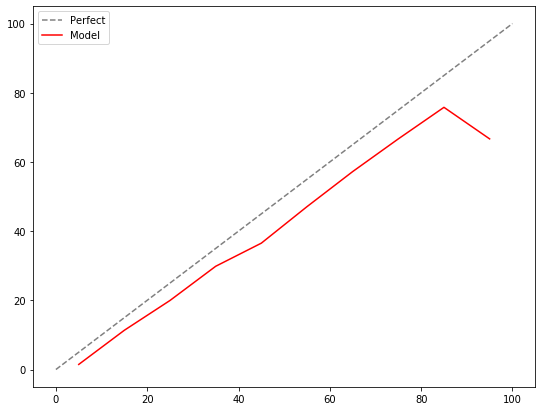

In [200]:
graph_maker.plot_calibration('greek')

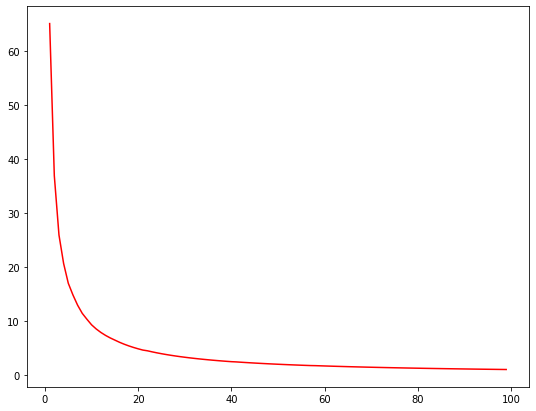

In [205]:
graph_maker.plot_lift('japanese', ratio=True)